In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib
from vb_lib.preconditioner_lib import get_mfvb_cov

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

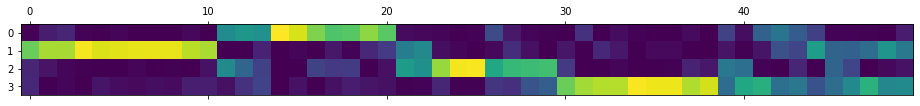

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(50, 100, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (50, 7) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (50, 7) (lb=0.0001, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks, 
                                              seed = 143241)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

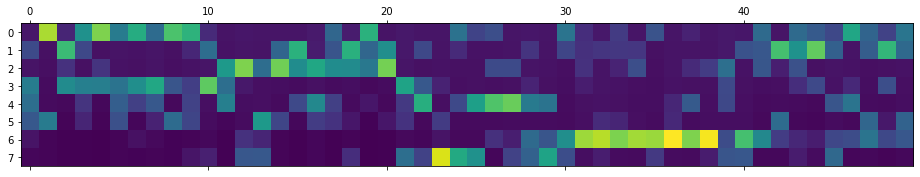

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

In [14]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            use_logitnormal_sticks,
                            gh_loc, gh_weights)

20833.34998402244

# Run CAVI

In [14]:
# get beta parameters for sticks and populations
vb_opt_dict, vb_opt, ez_opt, _, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        gh_loc = gh_loc, gh_weights = gh_weights, 
                        max_iter = 1000,
                        x_tol = 1e-4, 
                     print_every = 20)


iteration [20]; kl:7611.008544; elapsed: 0.4938secs
iteration [40]; kl:7580.221172; elapsed: 0.4873secs
iteration [60]; kl:7563.286885; elapsed: 0.4908secs
iteration [80]; kl:7543.804164; elapsed: 0.4888secs
iteration [100]; kl:7525.069454; elapsed: 0.6165secs
iteration [120]; kl:7506.247555; elapsed: 0.6641secs
iteration [140]; kl:7491.126449; elapsed: 0.5885secs
iteration [160]; kl:7485.143513; elapsed: 0.6109secs
iteration [180]; kl:7482.481537; elapsed: 0.506secs
iteration [200]; kl:7480.535632; elapsed: 0.8047secs
iteration [220]; kl:7476.062269; elapsed: 0.4873secs
iteration [240]; kl:7469.307059; elapsed: 0.6215secs
iteration [260]; kl:7451.649883; elapsed: 0.4875secs
iteration [280]; kl:7432.867536; elapsed: 0.6751secs
iteration [300]; kl:7396.850554; elapsed: 0.4882secs
iteration [320]; kl:7346.038462; elapsed: 0.481secs
iteration [340]; kl:7342.07573; elapsed: 0.5104secs
iteration [360]; kl:7341.720036; elapsed: 0.7884secs
iteration [380]; kl:7341.697359; elapsed: 0.6398secs


In [15]:
structure_model_lib.assert_optimizer(g_obs, vb_opt_dict, vb_params_paragami,
                        prior_params_dict, gh_loc, gh_weights,
                        use_logitnormal_sticks)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/vb_lib/structure_model_lib.py:471: UserWarning: l-inf gradient at optimum is : 0.0007887916951005991
  warnings.warn('l-inf gradient at optimum is : {}'.format(linf_grad))


# Define objective

In [16]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, 
                                       use_logitnormal_sticks = use_logitnormal_sticks, 
                                    gh_loc = gh_loc, gh_weights = gh_weights)


In [17]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [18]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.009sec


In [19]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.0272sec


In [20]:
# if its impossible, don't run the hessian
run_hessian = False

In [21]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

In [22]:
# cross hessian 
hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=1)

In [23]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 1.78sec


In [24]:
t0 = time.time()
hvp = obj_fun_hvp(vb_opt, prior_params_free, vb_opt)
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.0891sec


# Solver times

In [25]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))
    

In [26]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 4.73sec


In [27]:
t0 = time.time()
mfvb_preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 0.236sec


In [28]:
cg_solver_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': mfvb_preconditioner})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))



preconditioned solver time: 2.84sec


In [29]:
if run_hessian: 
    print(np.abs(dinput_dhyper[:, 0] - dinput_dhyper2).max())
    
print(np.abs(dinput_dhyper3 - dinput_dhyper2).max())

0.00012309343877253687
